# Compare warm and cold state in FOCI-OpenIFS

We are analysing the simulation FOCI_GJK001 performed on HLRN-Gottingen, late 2021. 
Tco95L91 + ORCA05L46

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
import cartopy.feature as cfeature
import string
from scipy.stats import ttest_ind
import seawater as sw
from scipy.interpolate import griddata

In [3]:
from dask.distributed import Client, LocalCluster, wait

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:34815 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [6]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read grid info

In [7]:
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read LSM

In [8]:
file = '%s/%s/outdata/oifs/lsm_regular.nc' % (esmdir,'FOCI_GJK006')
ds_lsm = xr.open_dataset(file, use_cftime=True)
lsm = ds_lsm['lsm'][0,:,:]

## Read OpenIFS data

In [9]:
exp_list = ['FOCI_GJK001', 'FOCI_GJK006']
label_list = ['Warm phase','Cold phase']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [10]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/*1m*regular_sfc.nc


In [11]:
ds_sfc_1m = xr.concat( ds_sfc_all, dim='time' )
ds_sfc_1m

<xarray.Dataset>
Dimensions:               (lat: 96, lon: 192, time: 25200, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 1850-01-16 12:00:00 ... 3949-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables: (12/43)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ...                    ...
    swvl1                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl2                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl3                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl4                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    sro                   (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ssro                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2021-Nov-12 19:21:56 GMT
    uuid:         0c810368-fe66-48aa-9163-86fa3ed8dac8
    history:      Sun Nov 14 21:27:08 2021: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

## Read NEMO data

In [10]:
# NEMO zonal means
ds_nemo_zm_all = []
for exp,time in zip(exp_list,time_list):
    zm = '%s/%s/outdata/nemo/cdf_analysis/*1m*grid_T_zm.nc' % (esmdir,exp)
    print(zm)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_zm = xr.open_mfdataset(zm,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_nemo_zm_all.append(ds_zm)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/*1m*grid_T_zm.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/*1m*grid_T_zm.nc


In [12]:
# NEMO monthly
ds_nemo_t_all = []
for exp,time in zip(exp_list,time_list):
    t = '/%s/%s/outdata/nemo/r180x90/%s*1m*grid_T.nc' % (esmdir,exp,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_nemo_t_all.append(ds_t)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/r180x90/FOCI_GJK001*1m*grid_T.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/r180x90/FOCI_GJK006*1m*grid_T.nc


In [13]:
ds_nemo_t = xr.concat( ds_nemo_t_all, dim='time' )

In [12]:
# NEMO monthly
ds_orca_t_all = []
for exp,time in zip(exp_list,time_list):
    t = '/%s/%s/outdata/nemo/%s*1m*grid_T.nc' % (esmdir,exp,exp)
    print(t)
    #ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    # This should be faster
    ds_t = xr.open_mfdataset(t,combine='nested', 
                             concat_dim="time_counter",
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True).rename({'time_counter':'time'}).sel(time=time)
    ds_orca_t_all.append(ds_t)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/FOCI_GJK001*1m*grid_T.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/FOCI_GJK006*1m*grid_T.nc


In [13]:
ds_orca_t = xr.concat( ds_orca_t_all, dim='time' )

In [14]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    lat = ds_moc['nav_lat'][0,:,0].data # .data is required in newer xarray versions
    ds_moc_lat = ds_moc.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_moc_all.append(ds_moc_lat)
    
    psi = '%s/%s/outdata/nemo/cdf_analysis/%s*1y*PSI_r360x180.nc' % (esmdir,exp,exp)
    print(psi)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1y*PSI_r360x180.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1y*PSI_r360x180.nc


In [15]:
ds_psi = xr.concat( ds_psi_all, dim='time' )
ds_moc = xr.concat( ds_moc_all, dim='time' )

In [16]:
def welch_ttest(x, y):
    t, p = ttest_ind(x, y, equal_var=False)
    return p

## Define phases

In [17]:
#periods = [slice('2000-01-01','2500-01-01'), slice('2580-01-01','3300-01-01'), slice('3350-01-01','3550-01-01')]
#periods_yr = [slice(2000,2500), slice(2580,3300), slice(3350,3550)]
periods = [slice('2000-01-01','2450-01-01'), slice('2550-01-01','3150-01-01'), slice('3300-01-01','3510-01-01')]
periods_yr = [slice(2000,2450), slice(2550,3150), slice(3300,3551)]
label = ['Phase1','Phase2','Phase3']

## Difference in T2M, sea ice and MLD

In [16]:
t2m_list = []
ice_list = []
mld_list = []

t2m_std = []
ice_std = []
mld_std = []

_t2m_ym = ds_sfc_1m['2t'].groupby('time.year').mean('time')
_ice_ym = ds_sfc_1m['ci'].sel(time=ds_sfc_1m['ci'].time.dt.month.isin([1, 2, 3])).groupby('time.year').mean('time')
_mld_ym = ds_nemo_t['somxl010'].sel(time=ds_nemo_t['somxl010'].time.dt.month.isin([1, 2, 3])).groupby('time.year').mean('time')

# 20-100 year filter
_t2m_filt = _t2m_ym.rolling(year=20).mean() - _t2m_ym.rolling(year=100).mean()
_ice_filt = _ice_ym.rolling(year=20).mean() - _ice_ym.rolling(year=100).mean()
_mld_filt = _mld_ym.rolling(year=20).mean() - _mld_ym.rolling(year=100).mean()

iref = 1

for i, (period, period_yr) in enumerate( zip(periods, periods_yr) ):
    
    # Select period and average (whole year)
    _t2m = ds_sfc_1m['2t'].sel(time=period).mean('time').compute()
    
    # First select time perid
    _ice_tmp = ds_sfc_1m['ci'].sel(time=period)
    _mld_tmp = ds_nemo_t['somxl010'].sel(time=period)
    
    # Then select winter months and average
    _ice = _ice_tmp.sel(time=_ice_tmp.time.dt.month.isin([1, 2, 3])).mean('time').compute()
    _mld = _mld_tmp.sel(time=_mld_tmp.time.dt.month.isin([1, 2, 3])).mean('time').compute()
    
    t2m_list.append(_t2m)
    ice_list.append(_ice)
    mld_list.append(_mld)
    
    # Select period and take std (whole year)
    _t2m = _t2m_filt.sel(year=period_yr).std('year').compute()
    t2m_std.append(_t2m)
    
    # Then select winter months and take std
    _ice = _ice_filt.sel(year=period_yr).std('year').compute()
    _mld = _mld_filt.sel(year=period_yr).std('year').compute()
    
    ice_std.append(_ice)
    mld_std.append(_mld)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWa

In [26]:
iref = 1

t2m_pval = []
ice_pval = []
mld_pval = []

for i, (period, period_yr) in enumerate( zip(periods, periods_yr) ):
    
    # we dont do it for the reference period (the cold period)
    if i != iref:
        
        # apply_ufunc requires that both dimensions are equal
        # But this is not the case for our Welch test where
        # dataarrays have different length in time. 
        # Solution: Rename one dimension to year2
        _data1 = _t2m_filt.sel(year=period_yr)
        _data2 = _t2m_filt.sel(year=periods_yr[iref]).rename({'year':'year2'})
        
        # Use apply_ufunc to do Welch test for each grid point (x,y)
        # We have allow_rechunk so that dask can rechunk array 
        # as it wants. This can lead to heavy mem use, but fine here
        _t2m_pval  = xr.apply_ufunc(welch_ttest,
                                    _data1, _data2,
                                    vectorize=True, dask='parallelized',
                                    input_core_dims=[['year'], ['year2']],
                                    output_dtypes=['d'],
                                    dask_gufunc_kwargs={'allow_rechunk':True},
                                   ).compute()
        t2m_pval.append(_t2m_pval)
        
        # Rinse and repeat for mld and ice
        _data1 = _ice_filt.sel(year=period_yr)
        _data2 = _ice_filt.sel(year=periods_yr[iref]).rename({'year':'year2'})
        _ice_pval  = xr.apply_ufunc(welch_ttest,
                                    _data1, _data2,
                                    vectorize=True, dask='parallelized',
                                    input_core_dims=[['year'], ['year2']],
                                    output_dtypes=['d'],
                                    dask_gufunc_kwargs={'allow_rechunk':True},
                                   ).compute()
        ice_pval.append(_ice_pval)
        
        _data1 = _mld_filt.sel(year=period_yr)
        _data2 = _mld_filt.sel(year=periods_yr[iref]).rename({'year':'year2'})
        _mld_pval  = xr.apply_ufunc(welch_ttest,
                                    _data1, _data2,
                                    vectorize=True, dask='parallelized',
                                    input_core_dims=[['year'], ['year2']],
                                    output_dtypes=['d'],
                                    dask_gufunc_kwargs={'allow_rechunk':True},
                                   ).compute()
        mld_pval.append(_mld_pval)
        
    else:
        t2m_pval.append(None)
        ice_pval.append(None)
        mld_pval.append(None)
    

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/gufunc.py:430: PerformanceWarning: Increasing number of chunks by factor of 24
  func, loop_output_dims, *arginds, concatenate=True, **kwargs
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/gufunc.py:430: PerformanceWarning: Increasing number of chunks by factor of 24
  func, loop_output_dims, *arginds, concatenate=True, **kwargs
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/gufunc.py:430: PerformanceWarning: Increasing number of chunks by factor of 24
  func, loop_output_dims, *arginds, concatenate=True, **kwargs
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/gufunc.py:430: PerformanceWarning: Increasing number of chunks by factor of 14
  func, loop_output_dims, *arginds, concatenate=True, **kwargs
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-pa

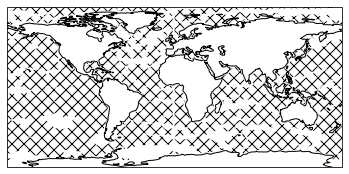

In [35]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
#_t2m_pval.plot(transform=ccrs.PlateCarree())
mld_pval[0].plot.contourf(ax=ax,levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                       colors='none', hatches=(None, 'xx'),
                       add_colorbar=False)
ax.coastlines()

## Plot diff in mean T2m and MLD between cold and warm phase

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


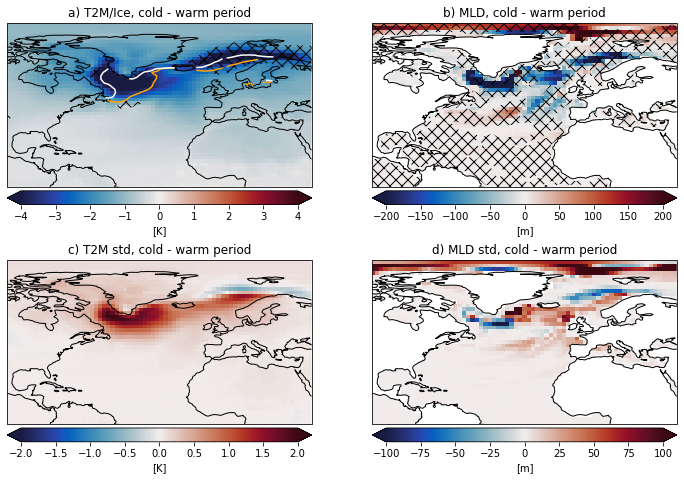

In [54]:
fig1, axs1 = plt.subplots(2, 2, figsize=(12,8), 
                          subplot_kw={'projection':ccrs.PlateCarree()})
ax1 = axs1.flat

# changes to all plots
cbar_kwargs = {'orientation':'horizontal','extend':'both','pad':0.02}
_cbar_kwargs = cbar_kwargs.copy()

# for T2m plots, we use K
_cbar_kwargs['label'] = '[K]'

# Phase 2 (cold) minus Phase 1 (warm)
(t2m_list[1] - t2m_list[0]).plot(ax=ax1[0], 
                                 vmin=-4, vmax=4,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=_cbar_kwargs,
                                 transform=ccrs.PlateCarree(),
                                 rasterized=True)

# draw 15% ice contours for both periods
# Use land-sea mask to avoid contours on land
_ice1 = ice_list[1].where(lsm < 0.5)
_ice0 = ice_list[0].where(lsm < 0.5)
_ice1.plot.contour(ax=ax1[0],levels=[0.15],colors='orange')
_ice0.plot.contour(ax=ax1[0],levels=[0.15],colors='white')

# draw 0.05 pval from Welch test
t2m_pval[0].plot.contourf(ax=ax1[0],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                          colors='none', hatches=(None, 'xx'),
                          add_colorbar=False)

# set title
ax1[0].set_title('a) T2M/Ice, cold - warm period')

# plot diff in std
(t2m_std[1] - t2m_std[0]).plot(ax=ax1[2], 
                               vmin=-2, vmax=2,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=_cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[2].set_title('c) T2M std, cold - warm period')

# now switch to m for MLD
_cbar_kwargs['label'] = '[m]'
(mld_list[1] - mld_list[0]).plot(ax=ax1[1], 
                                 vmin=-200, vmax=200,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=_cbar_kwargs,
                                 transform=ccrs.PlateCarree(),
                                 rasterized=True)

mld_pval[0].plot.contourf(ax=ax1[1],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                          colors='none', hatches=(None, 'xx'),
                          add_colorbar=False)

ax1[1].set_title('b) MLD, cold - warm period')

(mld_std[1] - mld_std[0]).plot(ax=ax1[3], 
                               vmin=-100, vmax=100,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=_cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[3].set_title('d) MLD std, cold - warm period')

# for all plots
for ax in ax1:
    ax.coastlines() # add coastlines
    ax.set_xlim([-100,40]) # focus on N Atl
    ax.set_ylim([0,90])
    ax.set_aspect('auto') # aspect follows plot shape, not map 

# we have used rasterized=True and save with dpi=150
# figures will not be vector graphics, instead 150 dpi
# but in PDF format to speed up PDFLatex
fig1.tight_layout()
fig1.savefig('figures/Fig_T2m_MLD_diff.pdf',format='pdf',dpi=150)

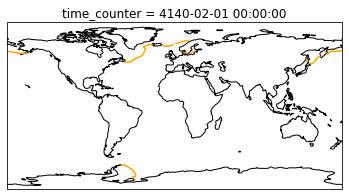

In [49]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
# draw 15% ice contours for both periods
_ice1 = ice_list[1].where(lsm < 0.5)
_ice1.plot.contour(ax=ax,levels=[0.15],colors='orange')
#ice_list[0].plot.contour(ax=ax,levels=[0.15],colors='white')
ax.coastlines()


## Repeat for 2nd warm period

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


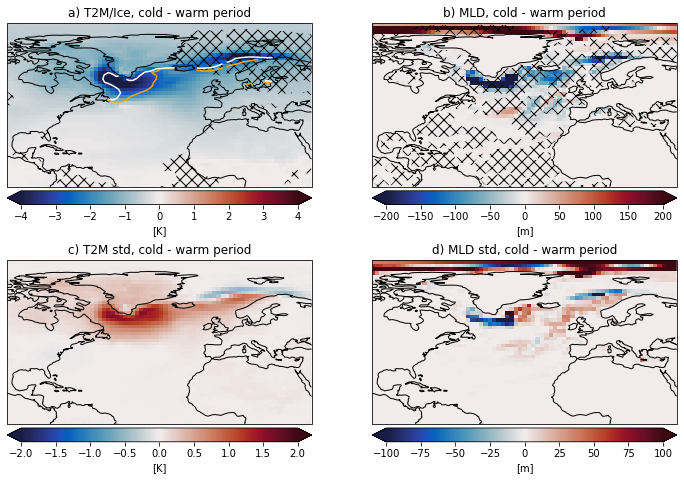

In [53]:
fig1, axs1 = plt.subplots(2, 2, figsize=(12,8), 
                          subplot_kw={'projection':ccrs.PlateCarree()})
ax1 = axs1.flat

# changes to all plots
cbar_kwargs = {'orientation':'horizontal','extend':'both','pad':0.02}
_cbar_kwargs = cbar_kwargs.copy()

# for T2m plots, we use K
_cbar_kwargs['label'] = '[K]'

# Phase 2 (cold) minus Phase 1 (warm)
(t2m_list[1] - t2m_list[2]).plot(ax=ax1[0], 
                                 vmin=-4, vmax=4,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=_cbar_kwargs,
                                 transform=ccrs.PlateCarree(),
                                 rasterized=True)

# draw 15% ice contours for both periods
_ice1 = ice_list[1].where(lsm < 0.5)
_ice0 = ice_list[2].where(lsm < 0.5)
_ice1.plot.contour(ax=ax1[0],levels=[0.15],colors='orange')
_ice0.plot.contour(ax=ax1[0],levels=[0.15],colors='white')

# draw 0.05 pval from Welch test
t2m_pval[2].plot.contourf(ax=ax1[0],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                          colors='none', hatches=(None, 'xx'),
                          add_colorbar=False)

# set title
ax1[0].set_title('a) T2M/Ice, cold - warm period')

# plot diff in std
(t2m_std[1] - t2m_std[2]).plot(ax=ax1[2], 
                               vmin=-2, vmax=2,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=_cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[2].set_title('c) T2M std, cold - warm period')

# now switch to m for MLD
_cbar_kwargs['label'] = '[m]'
(mld_list[1] - mld_list[2]).plot(ax=ax1[1], 
                                 vmin=-200, vmax=200,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=_cbar_kwargs,
                                 transform=ccrs.PlateCarree(),
                                 rasterized=True)

mld_pval[2].plot.contourf(ax=ax1[1],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                          colors='none', hatches=(None, 'xx'),
                          add_colorbar=False)

ax1[1].set_title('b) MLD, cold - warm period')

(mld_std[1] - mld_std[2]).plot(ax=ax1[3], 
                               vmin=-100, vmax=100,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=_cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[3].set_title('d) MLD std, cold - warm period')

# for all plots
for ax in ax1:
    ax.coastlines() # add coastlines
    ax.set_xlim([-100,40]) # focus on N Atl
    ax.set_ylim([0,90])
    ax.set_aspect('auto') # aspect follows plot shape, not map 

# we have used rasterized=True and save with dpi=150
# figures will not be vector graphics, instead 150 dpi
# but in PDF format to speed up PDFLatex
fig1.tight_layout()
fig1.savefig('figures/Fig_T2m_MLD_diff_2nd.pdf',format='pdf',dpi=150)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


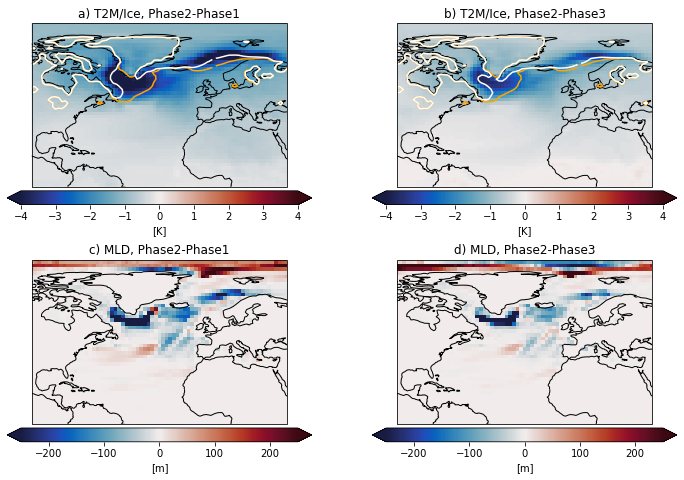

In [41]:
fig1, axs1 = plt.subplots(2, 2, figsize=(12,8), 
                          subplot_kw={'projection':ccrs.PlateCarree()})
ax1 = axs1.flat

cbar_kwargs = {'orientation':'horizontal','extend':'both','pad':0.02,'label':'[K]'}

# Phase 2 minus Phase 1
(t2m_list[1] - t2m_list[0]).plot(ax=ax1[0], 
                                 vmin=-4, vmax=4,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=cbar_kwargs,
                                 transform=ccrs.PlateCarree(),
                                rasterized=True)

ice_list[1].plot.contour(ax=ax1[0],levels=[0.15],colors='orange')
ice_list[0].plot.contour(ax=ax1[0],levels=[0.15],colors='white')
ax1[0].set_title('a) T2M/Ice, Phase2-Phase1')

# Phase 2 minus Phase 3
(t2m_list[1] - t2m_list[2]).plot(ax=ax1[1], 
                                 vmin=-4, vmax=4,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=cbar_kwargs,
                                 transform=ccrs.PlateCarree(),
                                rasterized=True)

ice_list[1].plot.contour(ax=ax1[1],levels=[0.15],colors='orange')
ice_list[2].plot.contour(ax=ax1[1],levels=[0.15],colors='white')
ax1[1].set_title('b) T2M/Ice, Phase2-Phase3')    

cbar_kwargs = {'orientation':'horizontal','extend':'both','pad':0.02,'label':'[m]'}

# Phase 2 minus Phase 1
mld_reg1 = nemo2ll(mld_list[1], mld_list[1]['nav_lon'], mld_list[1]['nav_lat'])
mld_reg0 = nemo2ll(mld_list[0], mld_list[0]['nav_lon'], mld_list[0]['nav_lat'])
(mld_reg1 - mld_reg0).plot(ax=ax1[2], 
                                 vmin=-250,vmax=250,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=cbar_kwargs,
                          rasterized=True)
ax1[2].set_title('c) MLD, Phase2-Phase1')

# Phase 2 minus Phase 3
mld_reg2 = nemo2ll(mld_list[2], mld_list[2]['nav_lon'], mld_list[2]['nav_lat'])
(mld_reg1 - mld_reg2).plot(ax=ax1[3], 
                                 vmin=-250,vmax=250,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=cbar_kwargs,
                          rasterized=True)
ax1[3].set_title('d) MLD, Phase2-Phase3')

for ax in ax1:
    ax.coastlines()
    ax.set_xlim([-100,40])
    ax.set_ylim([0,90])

fig1.tight_layout()
fig1.savefig('figures/T2m_ice_MLD_diffs.pdf',format='pdf')

## MLD variability

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


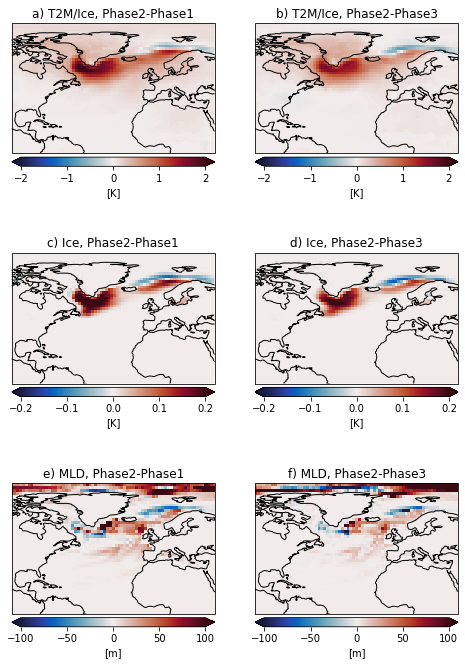

In [44]:
fig1, axs1 = plt.subplots(3, 2, figsize=(8,12), 
                          subplot_kw={'projection':ccrs.PlateCarree()})
ax1 = axs1.flat

cbar_kwargs = {'orientation':'horizontal','extend':'both','pad':0.02,'label':'[K]'}

# Phase 2 minus Phase 1
(t2m_std[1] - t2m_std[0]).plot(ax=ax1[0], 
                               vmin=-2, vmax=2,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[0].set_title('a) T2M/Ice, Phase2-Phase1')

# Phase 2 minus Phase 3
(t2m_std[1] - t2m_std[2]).plot(ax=ax1[1], 
                               vmin=-2, vmax=2,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[1].set_title('b) T2M/Ice, Phase2-Phase3')    

# Phase 2 minus Phase 1
(ice_std[1] - ice_std[0]).plot(ax=ax1[2], 
                               vmin=-0.2, vmax=0.2,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[2].set_title('c) Ice, Phase2-Phase1')

# Phase 2 minus Phase 3
(ice_std[1] - ice_std[2]).plot(ax=ax1[3], 
                               vmin=-0.2, vmax=0.2,
                               cmap=cmocean.cm.balance,
                               cbar_kwargs=cbar_kwargs,
                               transform=ccrs.PlateCarree(),
                               rasterized=True)

ax1[3].set_title('d) Ice, Phase2-Phase3') 

cbar_kwargs = {'orientation':'horizontal','extend':'both','pad':0.02,'label':'[m]'}

# Phase 2 minus Phase 1
mld_reg1 = nemo2ll(mld_std[1], mld_list[1]['nav_lon'], mld_list[1]['nav_lat'])
mld_reg0 = nemo2ll(mld_std[0], mld_list[0]['nav_lon'], mld_list[0]['nav_lat'])
(mld_reg1 - mld_reg0).plot(ax=ax1[4], 
                                 vmin=-100,vmax=100,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=cbar_kwargs,
                          rasterized=True)
ax1[4].set_title('e) MLD, Phase2-Phase1')

# Phase 2 minus Phase 3
mld_reg2 = nemo2ll(mld_std[2], mld_std[2]['nav_lon'], mld_list[2]['nav_lat'])
(mld_reg1 - mld_reg2).plot(ax=ax1[5], 
                                 vmin=-100,vmax=100,
                                 cmap=cmocean.cm.balance,
                                 cbar_kwargs=cbar_kwargs,
                          rasterized=True)
ax1[5].set_title('f) MLD, Phase2-Phase3')

for ax in ax1:
    ax.coastlines()
    ax.set_xlim([-100,40])
    ax.set_ylim([0,90])

fig1.tight_layout()
fig1.savefig('figures/T2m_ice_MLD_diffs_std_20-100yr.pdf',format='pdf')

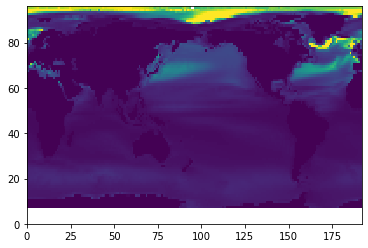

In [54]:
plt.pcolormesh(zi,vmin=0,vmax=500)

## Surface state

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


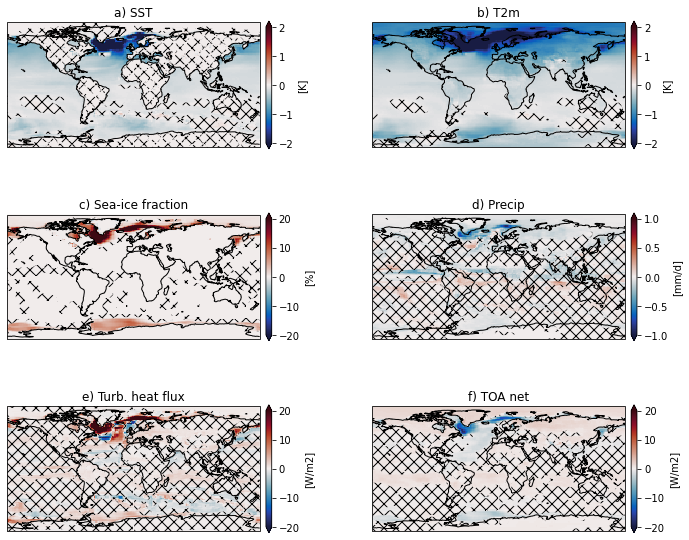

In [25]:
# Plot settings
prj = ccrs.PlateCarree()

cmap = cmocean.cm.balance

# Set up plot
fig1, axs1 = plt.subplots(3,2,figsize=(12,10),subplot_kw={'projection':prj})
ax1 = axs1.flat

i1 = 1
i2 = 0
label = '%s - %s' % (label_list[i1],label_list[i2])

letters = string.ascii_lowercase

variables = ['sstk','2t','ci','tp','ssf','toa']
for i,v in enumerate(variables): 
    
    scale = 1
    if v == 'sstk':
        vv = 'SST'
        unit = 'K'
        vmax = 2
        
    elif v == '2t':
        vv = 'T2m'
        unit = 'K'
        vmax = 2
    
    elif v == 'ci':
        vv = 'Sea-ice fraction'
        unit = '%'
        scale = 100
        vmax = 20
        
    elif v == 'tp':
        scale = 4000 # mm/d
        vv = 'Precip'
        unit = 'mm/d'
        vmax = 1
    
    elif v == 'msl':
        scale = 0.01
        vv = 'MSLP'
        unit = 'hPa'
        vmax = 1
    
    elif v == 'ssf':
        scale = 1./(6 * 60 * 60)
        vv = 'Turb. heat flux'
        unit = 'W/m2'
        vmax = 20
        
    elif v == 'toa':
        scale = 1./(6 * 60 * 60)
        vv = 'TOA net'
        unit = 'W/m2'
        vmax = 20
    
    if v == 'ssf':
        data1_1 = ds_sfc_all[i1]['sshf'].groupby('time.year').mean('time').compute() * scale
        data1_2 = ds_sfc_all[i1]['slhf'].groupby('time.year').mean('time').compute() * scale
        
        data2_1 = ds_sfc_all[i2]['sshf'].groupby('time.year').mean('time').compute() * scale
        data2_2 = ds_sfc_all[i2]['slhf'].groupby('time.year').mean('time').compute() * scale
        
        data1 = data1_1 + data1_2
        data2 = data2_1 + data2_2
        
    elif v == 'toa':
        data1_1 = ds_sfc_all[i1]['tsr'].groupby('time.year').mean('time').compute() * scale
        data1_2 = ds_sfc_all[i1]['ttr'].groupby('time.year').mean('time').compute() * scale
        
        data2_1 = ds_sfc_all[i2]['tsr'].groupby('time.year').mean('time').compute() * scale
        data2_2 = ds_sfc_all[i2]['ttr'].groupby('time.year').mean('time').compute() * scale
        
        data1 = data1_1 + data1_2
        data2 = data2_1 + data2_2
        
    else:
        data1 = ds_sfc_all[i1][v].groupby('time.year').mean('time').compute() * scale
        data2 = ds_sfc_all[i2][v].groupby('time.year').mean('time').compute() * scale
        
    mean_diff = data1.mean('year') - data2.mean('year')
    
    # Welch T-test
    # Probability that two sets of annual means have same mean (not assuming same variance)
    # First make data2 with same time axis so that xarray does not complain
    _data2 = data2.copy()
    _data2['year'] = data1['year']
    pval  = xr.apply_ufunc(welch_ttest,
                           data1, _data2,
                           vectorize=True, dask='parallelized',
                           input_core_dims=[['year'], ['year']],
                           output_dtypes=['d']).compute()
    
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'[%s]' % (unit,)}
    mean_diff.plot(ax=ax1[i],cmap=cmap,vmin=-vmax,vmax=vmax,cbar_kwargs=ckw,rasterized=True)
    
    # Plot dots where probability > 5%
    pval.plot.contourf(ax=ax1[i],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                       colors='none', hatches=(None, 'xx'),
                       add_colorbar=False)
    
    ax1[i].set_title('%s) %s' % (letters[i],vv))
    
for ax in ax1:
    ax.coastlines()

fig1.tight_layout()
fig1.savefig('figures/Fig_warm_vs_cold.pdf',format='pdf')

## Compute density

In [ ]:
rho0_mean = []

for i,ds in enumerate(ds_nemo_zm_all):
    
    if 1:
        tmean = ds['zotemper_atl']
        smean = ds['zosaline_atl']
    
        # take depth array (size 46) and duplicate along y dim (511)
        # gives depth as 46x511 array
        _p = np.array([tmean.deptht]*len(tmean.y))
        _press = np.array(len(tmean.x) * [_p]).T
        print(_press.shape)
        
        # compute density
        _rho = sw.dens(smean, tmean, _press)
        _rho0 = sw.pden(smean, tmean, _press, pr=0)
        
        _rho = np.nan_to_num(_rho)
        _rho0 = np.nan_to_num(_rho0)
        
        # put in dataarray
        da_rho = xr.DataArray( 
            data=_rho,
            dims=["deptht", "y", "x"],
            coords=dict(
                x=(["x"], np.arange(0,_rho.shape[2])),
                y=(["y"], np.arange(0,_rho.shape[1])),
                deptht=depth,
                ),
            attrs=dict(
                description="In-situ density",
                name='rho',
                units="kg/m3",
                ),
        )
        da_rho0 = xr.DataArray( 
            data=_rho0 - 1000,
            dims=["deptht", "y", "x"],
            coords=dict(
                x=(["x"], np.arange(0,_rho.shape[2])),
                y=(["y"], np.arange(0,_rho.shape[1])),
                deptht=depth,
                ),
            attrs=dict(
                description="Potential density (ref p=0)",
                name='sig0',
                units="kg/m3",
                ),
        )
        
        #_rho = np.ma.masked_where(da_orca05_mask_3D == 0, _rho)
        #_rho0 = np.ma.masked_where(da_orca05_mask_3D == 0, _rho0)
        
        rho_mean.append(da_rho.where(da_rho > 0))
        rho0_mean.append(da_rho0.where(da_rho0 > 0))

## Zonal mean T,S

Cold phase - Warm phase
<xarray.DataArray 'zotemper_glo' (deptht: 46, y: 511, x: 1)>
dask.array<sub, shape=(46, 511, 1), dtype=float32, chunksize=(46, 511, 1), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
Dimensions without coordinates: y, x


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'rasterized'


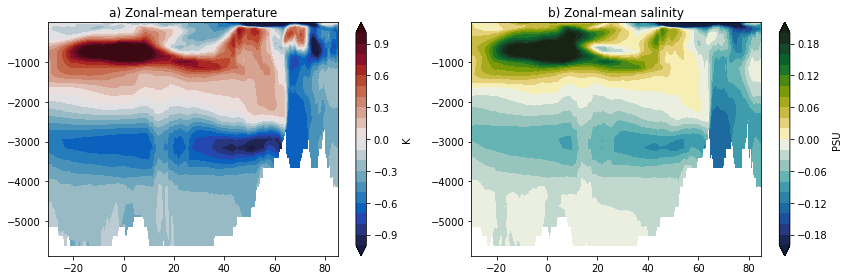

In [16]:
fig1, ax1 = plt.subplots(1,2, figsize=(12,4))

i1 = 1
i2 = 0

tlevels = np.linspace(-1,1,21)
slevels = np.linspace(-0.2,0.2,21)

if 1:
    
    ds_nemo_zm1 = ds_nemo_zm_all[i1]
    ds_nemo_zm2 = ds_nemo_zm_all[i2]
    
    label = '%s - %s' % (label_list[i1],label_list[i2])
    print(label)
    
    tem_zm_glo = ds_nemo_zm1['zotemper_glo'].mean('time') - ds_nemo_zm2['zotemper_glo'].mean('time')
    tem_zm_atl = ds_nemo_zm1['zotemper_atl'].mean('time') - ds_nemo_zm2['zotemper_atl'].mean('time')
    
    sal_zm_glo = ds_nemo_zm1['zosaline_glo'].mean('time') - ds_nemo_zm2['zosaline_glo'].mean('time')
    sal_zm_atl = ds_nemo_zm1['zosaline_atl'].mean('time') - ds_nemo_zm2['zosaline_atl'].mean('time')
    
    vlat = ds_nemo_zm1['nav_lat'][0,:,0]
    vdep = ds_nemo_zm1['deptht'][:]
    print(tem_zm_glo)
    
    cf1 = ax1[0].contourf(vlat, vdep, tem_zm_atl[:,:,0],
                          levels=tlevels, cmap=cmocean.cm.balance, 
                          extend='both', rasterized=True)
    
    cf2 = ax1[1].contourf(vlat, vdep, sal_zm_atl[:,:,0],
                          levels=slevels, cmap=cmocean.cm.delta, 
                          extend='both', rasterized=True)
    
    cb1 = plt.colorbar(cf1, ax=ax1[0])
    cb2 = plt.colorbar(cf2, ax=ax1[1])
    cb1.set_label('K')
    cb2.set_label('PSU')
    
    ax1[0].set_title('a) Zonal-mean temperature')
    ax1[1].set_title('b) Zonal-mean salinity')
    
    for ax in ax1:
        ax.set_xlim([-30,85])
        
fig1.tight_layout()
fig1.savefig('figures/Fig_warm_vs_cold_zonalmean_TS.pdf',format='pdf')

## Compare AMOC and barotropic stream functions

In [22]:
if 1:
    
    # take cold minus warm period
    period1 = periods[1]
    period2 = periods[0]
    
    ##
    ## Compute AMOC
    ## 
    print('AMOC1')
    _amoc1 = ds_moc['zomsfatl'].sel(x=0).sel(time=period1).groupby('time.year').mean('time').compute()
    print('AMOC2')
    _amoc2 = ds_moc['zomsfatl'].sel(x=0).sel(time=period2).groupby('time.year').mean('time').compute()
    amoc_lat = ds_moc['nav_lat'].isel(time=0,x=0)
    _amoc1 = _amoc1.where(_amoc1 != 0).assign_coords(y=amoc_lat)
    _amoc2 = _amoc2.where(_amoc2 != 0).assign_coords(y=amoc_lat)
    
    ##
    ## Compute barotropic stream function
    ##
    print('PSI1')
    _baro1 = ds_psi['sobarstf'].sel(time=period1).groupby('time.year').mean('time').compute() * 1e-6
    print('PSI2')
    _baro2 = ds_psi['sobarstf'].sel(time=period2).groupby('time.year').mean('time').compute() * 1e-6

    ##
    ## Differences
    ##
    amoc_diff = _amoc1.mean('year') - _amoc2.mean('year')
    baro_diff = (_baro1.mean('year') - _baro2.mean('year')).where(da_orca05_mask > 0)

AMOC1
AMOC2
PSI1
PSI2


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [28]:
baro_diff

<xarray.DataArray 'sobarstf' (lat: 180, lon: 360, y: 511, x: 722)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: y, x

<xarray.DataArray 'zomsfatl' (depthw: 46, y: 511)>
array([[        nan, -0.00044008, -0.00043193, ..., -0.08942688,
        -0.08921874, -0.08991587],
       [        nan,  0.00121186,  0.00101614, ..., -0.06232285,
        -0.06162238, -0.05576921],
       [        nan,  0.00208461,  0.00207429, ..., -0.05159879,
        -0.05153286, -0.04496193],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * depthw   (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
    lat      (y) float32 -76.95 -76.84 -76.73 -76.61 ... 89.6 89.79 89.94 89.79
    time     object 1850-01-16 12:00:00
  * y        (y) float32 -76.95 -76.84 -76.73 -76.61 ... 89.6 89.79 89.94 89.79


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


NameError: name 'ip' is not defined

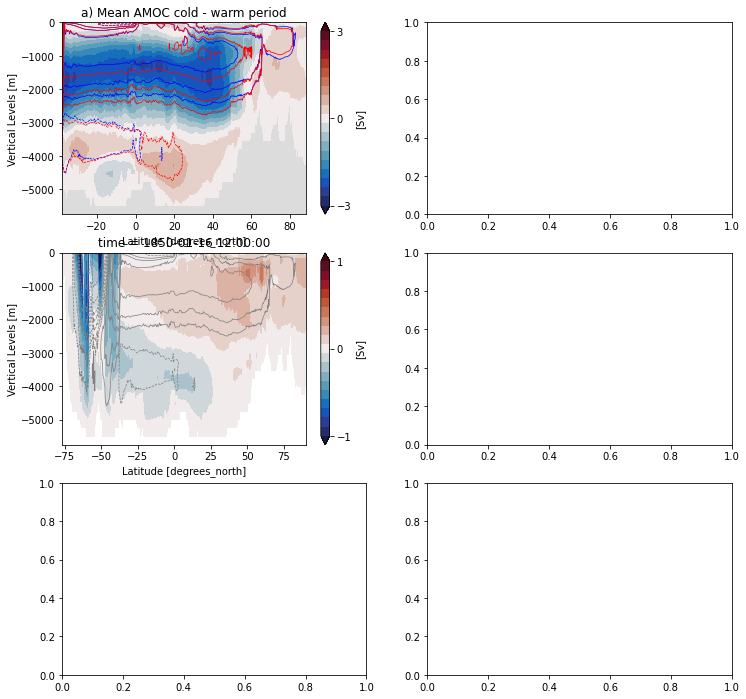

In [23]:
fig, ax = plt.subplots(3,2,figsize=(12,12))
bg_color = 'Gainsboro'

#
# Mean AMOC
#
mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
mlevels2 = np.linspace(-3,3,20)
cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
print(amoc_diff)
amoc_diff.plot.contourf(ax=ax[0,0], levels=mlevels2, extend='both',
                        cmap=cmocean.cm.balance,
                        cbar_kwargs=cbar_kwargs)
_amoc1.mean('year').plot.contour(ax=ax[0,0],colors='blue',levels=mlevels,linewidths=0.7)
_amoc2.mean('year').plot.contour(ax=ax[0,0],colors='red',levels=mlevels,linewidths=0.7)
ax[0,0].set_title('a) Mean AMOC cold - warm period')
ax[0,0].set_facecolor(bg_color)
ax[0,0].set_xlim([-38,88])
ax[0,0].set_xticks([-20,0,20,40,60,80])

#
# AMOC standard dev.
#
run1,run2=20,100
_amoc1_f = _amoc1.rolling(year=run1,center=True).mean() - _amoc1.rolling(year=run2,center=True).mean()
_amoc2_f = _amoc2.rolling(year=run1,center=True).mean() - _amoc2.rolling(year=run2,center=True).mean()
_amoc1_std = _amoc1_f.std('year')
_amoc2_std = _amoc2_f.std('year')
amoc_std_diff = _amoc1_std - _amoc2_std
    
mlevels2 = np.linspace(-1,1,20)
cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
(amoc_std_diff).plot.contourf(ax=ax[1,0],
                              levels=mlevels2,
                              extend='both',
                              cbar_kwargs=cbar_kwargs,
                              cmap=cmocean.cm.balance,
                              )
_amoc1.mean('year').plot.contour(ax=ax[1,0],colors='gray',levels=mlevels,linewidths=0.7)
ax[1,0].set_title('c) Std AMOC %s - %s' % (label_list[ip],label_list[jp]))
ax[1,0].set_facecolor(bg_color)
ax[1,0].set_xlim([-38,88])
ax[1,0].set_xticks([-20,0,20,40,60,80])

#
# Mean barotropic
#
mlevels = np.array([-150,-100,-80,-50,-30,-20,-10,10,20,30,50,80,100,150])
mlevels2 = np.linspace(-10,10,20)
cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
baro_diff.plot.contourf(ax=ax[0,1], levels=mlevels2, 
                        extend='both', rasterized=True,
                        cmap=cmocean.cm.balance,
                        cbar_kwargs=cbar_kwargs)
_baro2.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[0,1],colors='blue',levels=mlevels,linewidths=0.7)
_baro1.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[0,1],colors='red',levels=mlevels,linewidths=0.7)
ax[0,1].set_title('b) Mean PSI %s - %s' % (label_list[ip],label_list[jp]))
ax[0,1].set_facecolor(bg_color)

#
# Barotropic standard dev.
#
_baro1_f = _baro1.rolling(year=run1,center=True).mean() - _baro1.rolling(year=run2,center=True).mean()
_baro2_f = _baro2.rolling(year=run1,center=True).mean() - _baro2.rolling(year=run2,center=True).mean()
_baro1_std = _baro1_f.std('year')
_baro2_std = _baro2_f.std('year')
baro_std_diff = (_baro2_std - _baro1_std).where(da_orca05_mask > 0)
mlevels2 = np.linspace(-4,4,20)
cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
(baro_std_diff).plot.contourf(ax=ax[1,1],
                              levels=mlevels2,
                              extend='both',
                              cbar_kwargs=cbar_kwargs,
                              cmap=cmocean.cm.balance,
                              rasterized=True)
_baro1.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[1,1],colors='gray',levels=mlevels,linewidths=0.7)
ax[1,1].set_title('d) Std PSI %s - %s' % (label_list[ip],label_list[jp]))
ax[1,1].set_facecolor(bg_color)

## Compute deep convection

In [34]:
def compute_dmv(mld, dx, dy, zcrit=800, sv=True):
    """ 
    Compute deep convective volume as Brodeau and Koenigk (2016). 
    
    For North Atlantic, take MLD in March, find all points where MLD > zcrit
    and compute the total volume (MLD * dxdy) where MLD > zcrit. 
    Express in Sv as MLD * dxdy/1yr
    
    For the Southern Ocean, we use same criterion, but now look at September, 
    which is the season where open-ocean deep convection mostly occurs. 
    """
    
    # North Atlantic indices
    ni1, ni2, nj1, nj2 = 450, 550, 350, 450
    si1, si2, sj1, sj2 = 480, 600, 50, 150
    
    # Area
    narea = da_orca05_area.sel(x=slice(ni1,ni2),y=slice(nj1,nj2))
    sarea = da_orca05_area.sel(x=slice(si1,si2),y=slice(sj1,sj2))
    
    # Select March and make annual mean
    _mld_m = mld.sel(time=mld.time.dt.month.isin([3])).groupby('time.year').mean('time')
    
    # Select September
    _mld_s = mld.sel(time=mld.time.dt.month.isin([9])).groupby('time.year').mean('time')
    
    # Count occurrences
    _mld_m_tot = xr.where(_mld_m >= zcrit, 1, 0).sum('year') / len(_mld_m['year'])
    _mld_s_tot = xr.where(_mld_s >= zcrit, 1, 0).sum('year') / len(_mld_s['year'])
    
    # Compute Deep Mixed Volume
    _dmv_n = (_mld_m.where(_mld_m >= zcrit).sel(x=slice(ni1,ni2),y=slice(nj1,nj2)) * narea).sum(('x','y'))
    _dmv_s = (_mld_s.where(_mld_s >= zcrit).sel(x=slice(si1,si2),y=slice(sj1,sj2)) * sarea).sum(('x','y'))
    
    if sv:
        scale = 1.0 / (365*24*60*60) * 1e-6
        _dmv_n = _dmv_n * scale
        _dmv_s = _dmv_s * scale
    
    _mld_m_tot.name = 'DMV_count_Mar'
    _mld_s_tot.name = 'DMV_count_Sep'
    _dmv_n.name = 'DMV_North'
    _dmv_s.name = 'DMV_South'
    
    ll = [_mld_m_tot.to_dataset(), _mld_s_tot.to_dataset(), _dmv_n.to_dataset(), _dmv_s.to_dataset()]
    ds = xr.merge(ll)
    
    return ds

In [35]:
ds_dmv = compute_dmv(ds_orca_t['somxl010'], ds_mesh['e1t'].sel(t=0), ds_mesh['e2t'].sel(t=0)).compute()

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


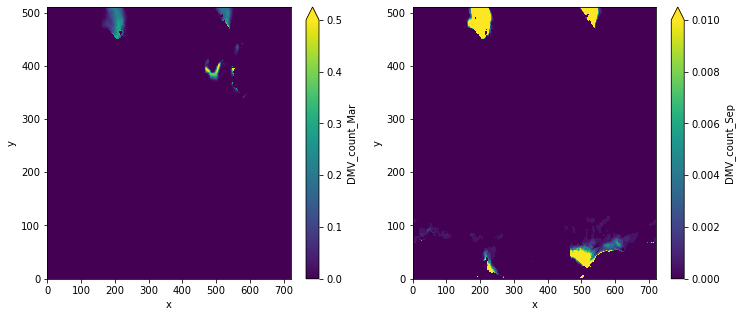

In [40]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ds_dmv['DMV_count_Mar'].plot(ax=ax[0], vmin=0,vmax=0.5)
ds_dmv['DMV_count_Sep'].plot(ax=ax[1], vmin=0,vmax=0.01)

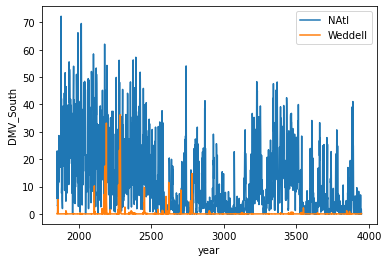

In [27]:
fig, ax = plt.subplots(1,1)
ds_dmv['DMV_North'].plot(ax=ax, label='NAtl')
ds_dmv['DMV_South'].plot(ax=ax, label='Weddell')
ax.legend()

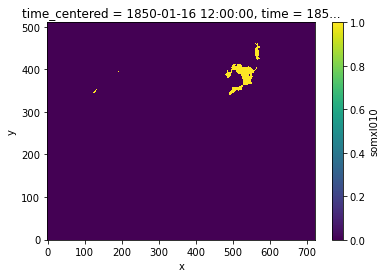

In [33]:
mld = ds_orca_t['somxl010'][0,:,:]
#mld.plot()

_mld = xr.where(mld >= 200, 1, 0) 
_mld.plot()

In [ ]:
fig1, axs1 = plt.subplots(2,2,figsize=(16,8))
fig2, axs2 = plt.subplots(1,2,figsize=(16,5))

for i in range(0,len(exp_list)):
    ds_t = ds_t_1m[i]
    exp = exp_list[i]
    mld = ds_t['somxl010']
    
    mld_s = mld.groupby('time.month').mean('time')
    
    # Select Feb and Sep
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[0,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[0,1])
    
    mld_s = mld.groupby('time.month').max('time')
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[1,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[1,1])
    
    # Convective volume (annual mean)
    mld_mask = mld.where(mld > 800).groupby('time.year').mean('time')
    # North Atlantic
    mld_natl = mld_mask.sel(x=slice(450,550),y=slice(350,450)) * da_orca05_area.sel(x=slice(450,550),y=slice(350,450))
    mld_natl_vol = mld_natl.sum(('x','y')) * 1e-12
    mld_natl_vol.plot(ax=axs2[0],label=exp)
    # Weddell Sea
    mld_wed = mld_mask.sel(x=slice(480,600),y=slice(50,150)) * da_orca05_area.sel(x=slice(480,600),y=slice(50,150))
    mld_wed_vol = mld_wed.sum(('x','y')) * 1e-12
    mld_wed_vol.plot(ax=axs2[1],label=exp)
    
axs2[0].set_title('Convective volume (>800m) North Atlantic')
axs2[1].set_title('Convective volume (>800m) Weddell Sea')
axs2[0].legend()
for ax in axs2:
    ax.set_ylabel('Deep convective volume (1000 km3)')

fig1.tight_layout()
fig2.tight_layout()
#fig1.savefig('mld_mean_max.png',format='png',dpi=150)
fig2.savefig('plots/deep_conv_vol.pdf',format='pdf')